In [1]:
import yaml
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt

In [2]:
results = \
    pd.read_csv("../results/mcmc_exp.csv", header=None)


results.columns = ["timestamp", "config", "precision", "recall", "f1_score"]
results.head()

,timestamp,config,precision,recall,f1_score
0,2023-11-10 16:24:02.198635,config/exp/catboost_10.yml,0.84615,0.57895,0.68750
1,2023-11-10 16:24:15.517950,config/exp/catboost_10.yml,0.75000,0.47368,0.58065
2,2023-11-10 16:24:29.003523,config/exp/catboost_10.yml,0.73333,0.57895,0.64706
3,2023-11-10 16:24:42.972325,config/exp/catboost_10.yml,0.60000,0.47368,0.52941
4,2023-11-10 16:24:57.109307,config/exp/catboost_10.yml,0.66667,0.52632,0.58824


In [3]:
def _parse_cfg(config):
    with open(f"../{config}") as f:
        tmp = yaml.safe_load(f)
    return tmp

def parse_clf(config):
    _config = _parse_cfg(config)
    clf = _config["mcmc"]["classifier"]
    return clf

def parse_ratio(config):
    _config = _parse_cfg(config)
    clf = _config["mcmc"]["ratio"]
    return clf

results["classifier"] = results.config.apply(parse_clf)
results["ratio"] = results.config.apply(parse_ratio)

In [4]:
results.head()

,timestamp,config,precision,recall,f1_score,classifier,ratio
0,2023-11-10 16:24:02.198635,config/exp/catboost_10.yml,0.84615,0.57895,0.68750,catboost,10
1,2023-11-10 16:24:15.517950,config/exp/catboost_10.yml,0.75000,0.47368,0.58065,catboost,10
2,2023-11-10 16:24:29.003523,config/exp/catboost_10.yml,0.73333,0.57895,0.64706,catboost,10
3,2023-11-10 16:24:42.972325,config/exp/catboost_10.yml,0.60000,0.47368,0.52941,catboost,10
4,2023-11-10 16:24:57.109307,config/exp/catboost_10.yml,0.66667,0.52632,0.58824,catboost,10


In [5]:
rs = pd.pivot_table(
    results,
    index = ["classifier"],
    columns = ["ratio"],
    values = "f1_score",
    # aggfunc= lambda x: f"{np.mean(x) : .3f}{np.std(x) : .3f}"
)

rs

ratio,1,2,3,4,5,6,7,8,9,10
classifier,,,,,,,,,,
catboost,0.826755,0.793027,0.744585,0.693478,0.690091,0.651986,0.594040,0.604383,0.540928,0.573465
decision_tree,0.821014,0.704476,0.668897,0.591105,0.545942,0.525366,0.463393,0.463379,0.425376,0.408973
gbc,0.825521,0.789609,0.756897,0.696321,0.669890,0.658642,0.570173,0.591867,0.497613,0.538522
knn,0.756220,0.653907,0.488371,0.479997,0.389439,0.381296,0.355922,0.271826,0.232267,0.266771
lr,0.801974,0.768491,0.701278,0.630293,0.575933,0.605193,0.511419,0.557939,0.456508,0.477671
mlp,0.801763,0.717047,0.634102,0.565230,0.605082,0.567365,0.469385,0.472331,0.395549,0.460051
svm,0.816330,0.784933,0.658000,0.626980,0.620092,0.519353,0.426883,0.379594,0.347551,0.353643


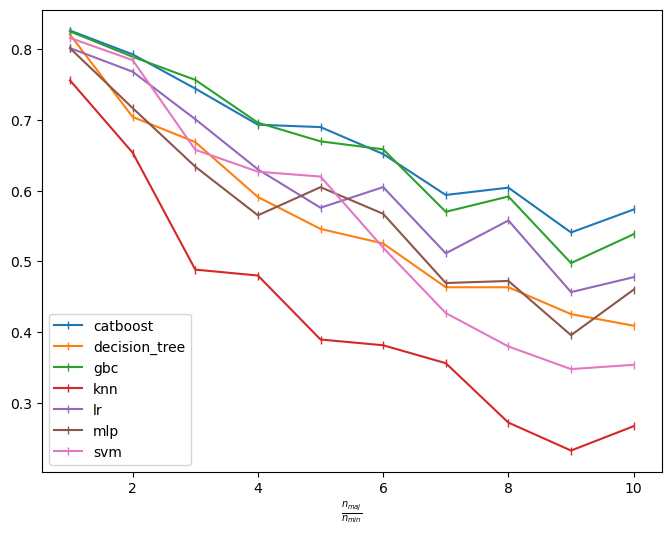

In [6]:

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [8, 6]

for clf in rs.index:
    rs.loc[clf].plot(label=clf, lw=1.5, marker="|")

plt.xlabel(r'$\frac{n_{maj}}{n_{min}}$')
# plt.ylim(.65, .95)
plt.legend(loc=3);

In [7]:
result_exp_baseline = pd.read_csv("../results/baseline-exp.csv", header=None)
result_exp_baseline.columns = \
    ["timestamp", "config", "precision", "recall", "f1_score"]

In [8]:
# result_exp_baseline.head()

In [9]:
def _parse_cfg(config):
    with open(f"../{config}") as f:
        tmp = yaml.safe_load(f)
    return tmp

def parse_clf(config):
    _config = _parse_cfg(config)
    clf = _config["baseline"]["classifier"]
    return clf

def parse_ratio(config):
    _config = _parse_cfg(config)
    clf = _config["baseline"]["ratio"]
    return clf

def parse_method(config):
    _config = _parse_cfg(config)
    clf = _config["baseline"]["sampler_name"]
    return clf

In [10]:
result_exp_baseline["classifier"] = result_exp_baseline.config.apply(parse_clf)
result_exp_baseline["ratio"] = result_exp_baseline.config.apply(parse_ratio)
result_exp_baseline["method"] = result_exp_baseline.config.apply(parse_method)

In [11]:
# result_exp_baseline.head()

In [12]:
results["method"] = "mcmc"
all_results = pd.concat([result_exp_baseline, results])
all_results.shape

(1420, 8)

In [13]:
# all_results

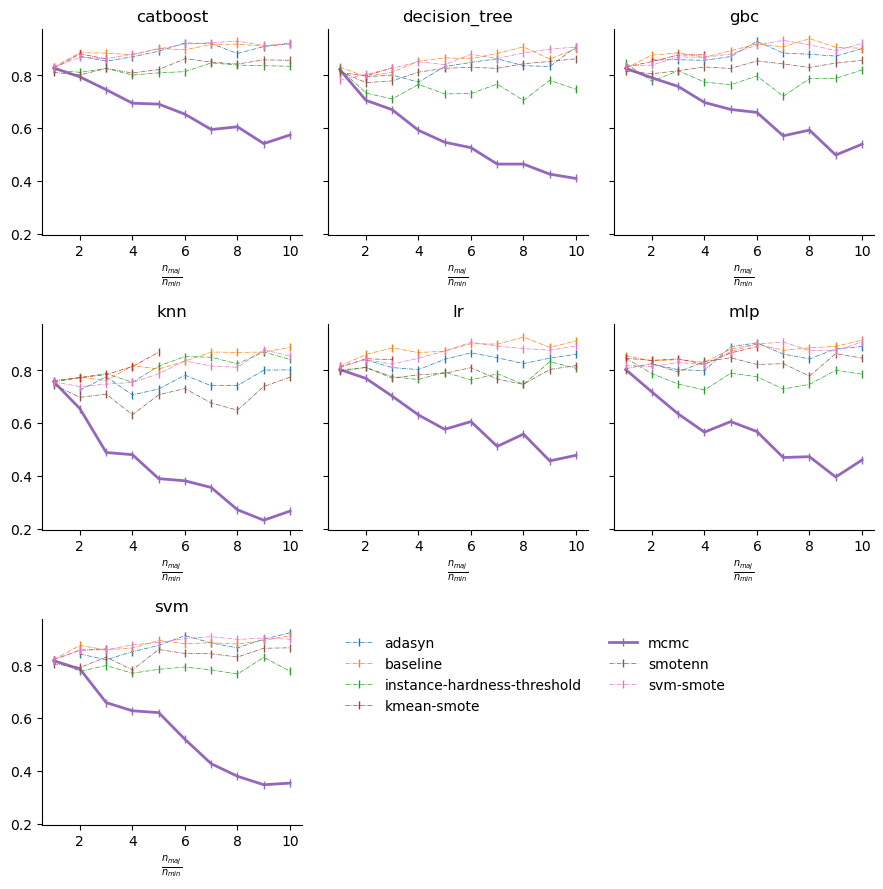

In [14]:
ls_clf = all_results.classifier.unique()

fig, axes = plt.subplots(ncols=3,nrows=3, figsize=[9, 9], sharey=True)
axes=axes.ravel()

for i, clf in enumerate(ls_clf):
    _rs = all_results.query("classifier == '{clf}'".format(clf=clf))
    
    _rs_pivot = pd.pivot_table(
        _rs,
        index="ratio",
        columns="method",
        values="f1_score",
        aggfunc=np.mean
    )
    
    for method in _rs_pivot.columns:
        # print(_rs_pivot.loc[:, method])
        axes[i].plot(_rs_pivot.loc[:, method], 
                     label=method, marker="|",
                     lw = 2 if method=="mcmc" else .5,
                     ls = "-."  if method != "mcmc" else None
                    )
    axes[i].set_title(clf)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel(r'$\frac{n_{maj}}{n_{min}}$')
    


axes[7].axis("off")
axes[8].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc="lower right",ncol=2, bbox_to_anchor=[.825, .1875])
plt.tight_layout()
fig.savefig("rs-exp-mean.png")